<h1><center> Mini Project 3 - Image Classification </center></h1>

<div style="text-align: right"> Amen Memmi</div>
<div style="text-align: right"> amen.memmi@mail.mcgill.ca</div>
<div style="text-align: right">  ID: 260755070</div>

### This notebook is my shot at the third mini project from COMP-551 course. I used transfer learning from Google's pre-trained deep neural network, Inception v3, for features extraction and then Naive Bayes and SVM for classification. This performed as the best classifier in my team, team Kakashi, with an accuracy of 88% on the test set. Details are below. 

The dataset for this project is based on the classic ImageNet dataset, however only a subset of
40 classes is considered, and each image has been modified to be smaller. The training set contains 26344 images while the test set is comprised of 6600 images.<br>
Examples of the training samples (1 per class) are shown below:

<img src="40_classes.png" alt="Drawing" align="left" style="width: 800px;"/>

In [1]:
import os
import re
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

# Features Extraction via Transfer learning

The pre-trained DNN I will be relying on is Inception-v3. It has been developed by Google and it has high classification performance and is easily available in TensorFlow.

First, I download the model in the directory model_dir I created in the project directory project_dir. <br>
<font color=grey> {{ To do so, download the model into the project directory by running in a terminal (after cloning https://github.com/tensorflow/models from github) :</font> <br>
<font color=grey> cd tensorflow/models/image/imagenet python classify_image.py --model_dir project_dir/model_dir }}</font>

In [2]:
# inception v3 model directory
model_dir = 'inception_model'


To use TensorFlow, a graph that represents the description of computations is needed. That's the __classify_image_graph_def.pb__ file we downloaded. Then these computations will be executed within what is called sessions. Let's define a function to create the graph from  the graph definition contained within the file I just mentioned:

In [3]:
def create_graph():
    """ Creates a graph from the graph definition saved in classify_image_graph_def.pb in the model directory """
    with gfile.FastGFile(os.path.join(
    model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

In [4]:
create_graph()

In [5]:
# loading data
trainX = np.load('tinyX.npy') # this should have shape (26344, 3, 64, 64)
trainY = np.load('tinyY.npy')

In [8]:
print(f'trainX shape: {trainX.shape}')
print(f'trainY shape: {trainY.shape}')

trainX shape: (26344, 3, 64, 64)
trainY shape: (26344,)


Now, we need to drop the last layer (as it is the classification layer and does not correspond to our classes) and export the next-to-last layer outputs as features for each image. In TensorFlow, this layer is called __pool_3__.

In [9]:
def extract_features(input_set):
    """ Returns the features corresponding to the output of thes next-to-last layer """
    nb_features = 2048
    features = np.empty((len(input_set),nb_features))
    create_graph()
    with tf.Session() as sess:
        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')
        for ind in tqdm_notebook(range(len(input_set))):
            predictions = sess.run(next_to_last_tensor, {'DecodeJpeg:0': input_set[ind].transpose(2,1,0)})
            features[ind,:] = np.squeeze(predictions)           
    return features

### Extracting training data features


In [10]:
%%time
trainX_features = extract_features(trainX)


Wall time: 1h 14min 40s


### Loading test data and Extracting test data features


In [12]:
testX = np.load('tinyX_test.npy') # (6600, 3, 64, 64)

In [13]:
%%time
# 
trainX_features_test = extract_features(testX)


Wall time: 18min 36s


Features are saved now so that they can be used without re-running this step of feature extraction, which can be relatively long (about 1h 30 min total on my laptop with i7 7700M CPU and 16 Go RAM).

In [15]:
# Exporting training data features
pickle.dump(trainX_features, open('trainX_features', 'wb'))

In [16]:
# Exporting test data features
pickle.dump(trainX_features_test, open('testX_features', 'wb'))

# Classification

In [17]:
# importing training set features and labels
with open('trainX_features', 'rb') as f:
    trainX_features = pickle.load(f)
trainY = np.load('tinyY.npy')

###  Performances Evaluation

In [18]:
# split into train & validation sets
F, F_val, Y, Y_val = train_test_split(trainX_features, trainY, test_size=0.33, random_state=17)

#### Naive Bayes classifier

In [8]:
#### Results of the MultinomialNB included in Sckit #########
K=100
accuracy=0.0
for k in tqdm_notebook(range(K)):
    # split into train & validation sets
    F, F_val, Y, Y_val = train_test_split(trainX_features, trainY, test_size=0.33, random_state=k)
    clf = MultinomialNB().fit(F, Y)
    po=clf.predict(F_val)
    accuracy+=accuracy_score(Y_val,po)*100
accuracy=accuracy/K
print(f"Accuracy: {accuracy}%")


Accuracy: 89.7%


#### SVM Classifier

In [11]:
#### Results of LinearSVC from scikit #########
K=10
accuracy=0.0
clf_SVM = LinearSVC(C=1.0, loss='squared_hinge', penalty='l2',multi_class='ovr')
for k in tqdm_notebook(range(K)):
    # split into train & validation sets
    F, F_val, Y, Y_val = train_test_split(trainX_features, trainY, test_size=0.33, random_state=17*k)
    clf_SVM.fit(F, Y)
    y_pred = clf_SVM.predict(F_val)
    accuracy+=accuracy_score(Y_val,y_pred)*100
accuracy=accuracy/K
print(f"Accuracy: {accuracy}%")


Accuracy: 91.3%


In [12]:
def plot_confusion_matrix(y_true,y_pred):
    cm_array = confusion_matrix(y_true,y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm_array[:-1,:-1], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels))
    ytick_marks = np.arange(len(pred_labels))
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks,pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size

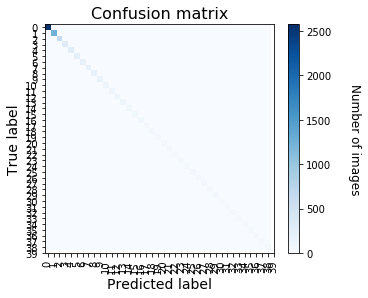

In [17]:
plot_confusion_matrix(Y_val,y_pred)

### Making the prediction for the test set

#### Training over the whole training set 

In [ ]:
%%time
clf_SVM = LinearSVC(C=1.0, loss='squared_hinge', penalty='l2',multi_class='ovr')
clf_SVM.fit(trainX_features, trainY)

#### Loading test features and predicting the output for the test set

In [ ]:
testX_features = pickle.load(open('testX_features'))
prediction = clf_SVM.predict(testX_features)

#### Exporting prediction  to csv 

In [ ]:
%%time
pred=[['id','class']]
for i in range(len(prediction)):
    pred.append([i, prediction[i]] ) 
with open("output_prediction.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(pred)

Submitting my prediction to the in-class Kaggle competition, I got 88% classification accuracy score, which is certainly a very good performance. This proves that this approach is quite interesting especially knowing that it only  took me a few lines of code and less than 2 hours of training on a laptop, of course compared to the whole process of deep learning that requires very large datasets and is quite time consuming.